In [ ]:
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import numpy as np
import tarfile 
import os

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def add_path(file_, path):
  '''
  add the images folder to the file name

  Args:
    file_ (str) --> file that is inside the folder
    path (str) --> folder that contains the files
  
  Returns:
    filepath (str) --> file with destination path
  '''

  return path + file_

In [ ]:
!cp -r /content/drive/MyDrive/datasets-projeto/nih-files /content

In [92]:
extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  file_ = tarfile.open(f'/content/nih-files/{files}') 
  file_.extractall('/content/') 
  file_.close() 

In [93]:
nih_df = pd.read_csv('/content/nih_original_csv_file.csv')
nih_df = nih_df.drop(['Follow-up #', 'Patient ID', 'Patient Age', 
                      'View Position', 'OriginalImage[Width', 'Height]', 
                      'OriginalImagePixelSpacing[x', 'y]'], axis = 1)

In [94]:
nih_df.rename(columns = {'Patient Gender': 'Sex'}, inplace = True)
nih_df['Sex'].replace({'M': 'male', 'F': 'female'}, inplace = True)

image_index = list(nih_df['Image Index'])
partial_add_path = partial(add_path, path = '/content/images/')
image_index = list(map(partial_add_path, image_index))

nih_df['Path'] = image_index
nih_df = nih_df.drop(['Image Index'], axis = 1)
nih_df['Dataset'] = ['NIH'] * len(nih_df)
nih_df['Label Type'] = ['Multilabel'] * len(nih_df)

In [122]:
abnormalities_combinations = list()
classes = ['Nodule', 'Effusion', 'Atelectasis',  'Pneumothorax', 'Mass']
all_classes = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
               'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
               'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
combinations = ['01', '02', '03', '04', '12', '13', '14',  '23', '24', '34',
                '012', '013', '014', '123', '124', '234', '0123', '0124', 
                '1234', '01234']

for combination in combinations:
  sub_classes = list()
  for element in list(combination):
    sub_classes.append(classes[int(element)])
  abnormalities_combinations.append(sub_classes)

In [123]:
values_ref = dict()
for combination_index in range(0, len(combinations)):
  values_ref[str(combination_index)] = list()

for index in range(0, len(nih_df)):
  for combination_index, combination in enumerate(abnormalities_combinations):
    no_contain = 0
    other_diseases = set(all_classes) - set(combination)
    for disease in combination:
      if disease in nih_df['Finding Labels'][index]: pass
      else: no_contain = 1
      for other_disease in other_diseases:
        if other_disease in nih_df['Finding Labels'][index]: no_contain = 1
    if no_contain == 0: values_ref[str(combination_index)].append(index)

Text(0.5, 1.0, 'Quantidade Total de Imagens: Base de Dados NIH - Multirrótulo')

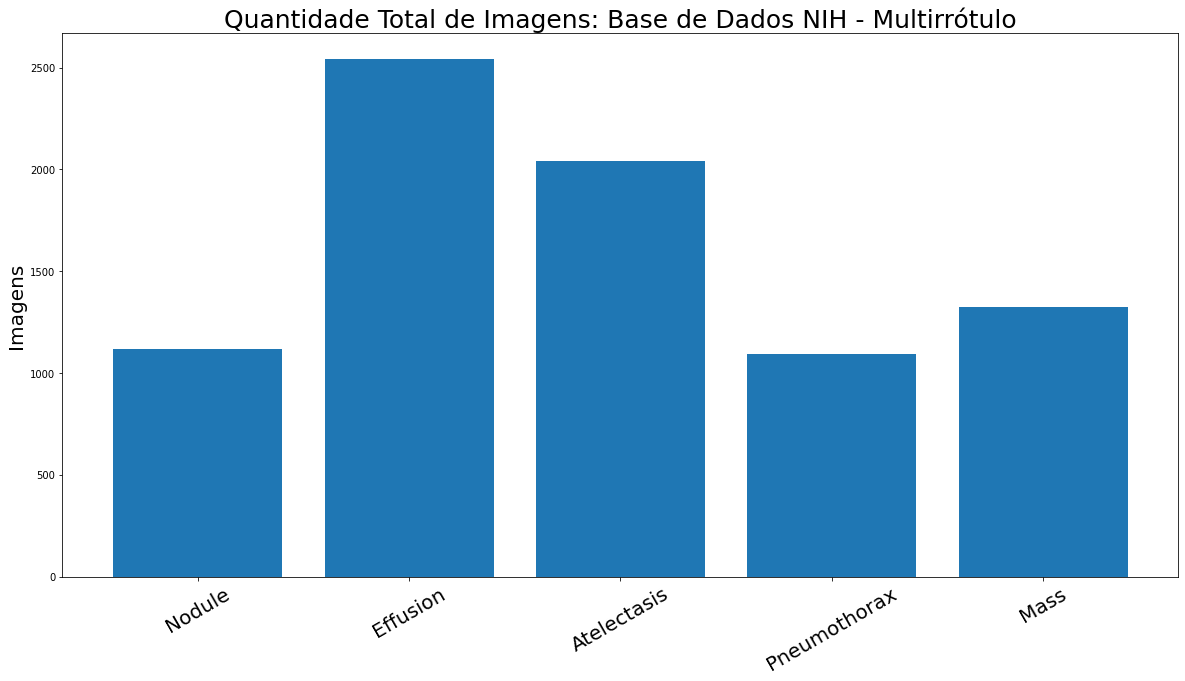

In [124]:
count_findings = dict()

for disease in classes:
  count_findings[disease] = 0

for combination_index, combination in enumerate(abnormalities_combinations):
  for disease in combination:
    count_findings[disease] += len(values_ref[str(combination_index)])

count_findings = list(count_findings.values())

plt.figure(figsize = (20, 10))
plt.bar(classes, count_findings)
plt.xticks(rotation = 30, size = 20)
plt.ylabel('Imagens', size = 20)
plt.title('Quantidade Total de Imagens: Base de Dados NIH - Multirrótulo', 
          size = 25)

In [125]:
for index, keys in enumerate(values_ref.keys()):
  dataset_aux = nih_df.iloc[values_ref[keys], :]
  if index == 0:
    nih_df_balanced = dataset_aux
  else:
    nih_df_balanced = pd.concat((nih_df_balanced, dataset_aux))

In [127]:
nih_df_balanced['No Finding'] = 0

finding_labels = list(nih_df_balanced['Finding Labels'])
one_hot_array = np.zeros((len(nih_df_balanced), len(classes)))

for index_labels, labels in enumerate(finding_labels):
  for index_disease, disease in enumerate(classes):
    if disease in labels:
      one_hot_array[index_labels, index_disease] = 1.0

for index, disease in enumerate(classes):
  nih_df_balanced[disease] = one_hot_array[:, index]

nih_df_balanced.drop('Finding Labels', axis = 1, inplace = True)
columns = np.concatenate((['Dataset', 'Path', 'Sex', 'Label Type', 'No Finding'], classes))
nih_df_balanced[columns]

In [138]:
nih_df_balanced.to_csv(path_or_buf = 'nih_df_multilabel.csv', columns = columns)